# Data 188: Homework 1

This homework will get you started with your implementation of the **needle** (**ne**cessary **e**lements of **d**eep **le**arning) library that you will develop throughout this course.  In particular, the goal of this assignment is to build a basic **automatic differentiation** framework, then use this to re-implement the simple two-layer neural network you used for the MNIST digit classification problem in HW0.

First, as you did for HW0, make a copy of this notebook file by selecting "Save a copy in Drive" from the "File" menu, and then run the code block below to set up and install the necessary packages.

Your "deliverables" for this homework will be changes to the following files:
- `apps/simple_ml.py`
- `python/needle/ops/ops_mathematic.py`
- `python/needle/autograd.py`

### Clarifications Doc

In case we need to give any clarifications (or hints!) for the assignment, see this Google Doc: ["HW1 Clarifications"](https://docs.google.com/document/d/1UaSnJvU3NuZtBjtb09qv-aMugmsaZb0ZmquCLbYOny4/edit?tab=t.0).
This doc will be regularly updated.

**Acknowledgement**: this assignment is based on HW1 of CMU's ["Deep Learning Systems"](https://dlsyscourse.org/) course (10-414/714, Fall 2025). Thanks to: Prof. Zico Kolter, Prof. Tianqi Chen, Prof. Tim Dettmers.

In [4]:
# Run this cell each time your kernel is disconnected or restarted
# Tip: it's always safe to re-run this, this will never delete data

import os
import sys

# basedir_course: All colab material for this course will live here.
#   Feel free to modify this if you'd like.
basedir_course = "/content/drive/MyDrive/data188"
# asn_name: name of assignment, eg hw0. This must match github repo name.
asn_name = "hw1"
rootdir_asn = os.path.join(basedir_course, asn_name)

# Fetch code to set up the assignment, then set the correct working directory
# (eg for python imports to work)
from google.colab import drive
drive.mount('/content/drive')

os.makedirs(basedir_course, exist_ok=True)
os.chdir(basedir_course)
os.system(f"git clone https://github.com/data188sp26/{asn_name}.git")
os.chdir(rootdir_asn)

# install required libraries
!pip3 install numdifftools

# Validate that our current working directory is correct.
# This should output:
#   /content/drive/MyDrive/data188/hw0/
print("Current working directory: ", os.getcwd())
# Another check: let's double check that the files in hw0/ are in the current directory.
# This should output something like:
#   ['.git', 'LICENSE', 'apps', 'data', 'hw0.ipynb', 'tests', '.pytest_cache']
print("ls cwd: ", os.listdir(os.getcwd()))

# ==== Important: modify path to allow `import needle` to work ====
# Implementation note: Annoyingly, we can't append to an existing env-var via
# ipython `set_env` like we can in bash (eg PYTHONPATH=new_path/:$PYTHONPATH).
# Instead we assume that PYTHONPATH starts as: /env/python, eg the below
# line is hopefully equivalent to:
#   PYTHONPATH=./python/:$PYTHONPATH
%set_env PYTHONPATH ./python/:./:/env/python
# We also need to modify sys.path directly so that the current python session
# can access needle
sys.path.insert(0, "./python")
sys.path.insert(1, "./")

print("Setup done!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory:  /content/drive/MyDrive/data188/hw1
ls cwd:  ['.git', '.gitattributes', '.gitignore', 'LICENSE', 'README.md', 'apps', 'data', 'hw1.ipynb', 'python', 'tests', 'utils_public', '.pytest_cache']
env: PYTHONPATH=./python/:./:/env/python
Setup done!


## Introduction to `needle`

For an introduction to the `needle` framework, refer to lecture. For this homework, you will be implementing the basics of automatic differentiation using a `numpy` CPU backend (in later assignments, you will move to your own linear algebra library including GPU code). All code for this assignment will be written in Python.

For the purposes of this assignment, there are two important files in the `needle` library, the `python/needle/autograd.py` file (which defines the basics of the computational graph framework, and also will form the basis of the automatic differentation framework), and the `python/needle/ops/ops_mathematic.py` file (which contains implementations of various operators that you will use implement throughout the assignment and the course).

Although the basic framework for automatic differentiation is already set up in the `autograd.py` file, you should familiarize yourself with the basic concepts of the library as it relates to a few different defined classes.  Note that we would **not** recommend attempting to read through the entire code base before starting your implementations (some of the functionality will likely make more sense after you have implemented something), but you should have a basic understanding.  Specifically, you should get familiar with the basic concepts behind the following classes:
- `Value`: A value computed in a compute graph, i.e., either the output of some operations applied to other `Value` objects, or a constant (leaf) `Value` objects  We use a generic class here (which we then specialize to e.g. Tensors), in order to allow for other data structures in later version of needle, but for now you will interact with this class mostly through it's subclass `Tensor` (see below).
- `Op`: An operator in a compute graph.  Operators need to define their "forward" pass in the `compute()` method (i.e., how to compute the operator on the underlying data of the `Value` objects), as well as their "backward" pass via the `gradient()` method, which defines how to multiply by incoming output gradients.  The details of writing such operators will be given below.
- `Tensor`: This is a subclass of `Value` that corresponds to an actual tensor output, i.e., a multi-dimensional array within a computation graph.  All of your code for this assignment (and most of the following) will use this subclass of `Value` rather than the generic class above.  We have provided several convevience functions (e.g., operator overloading) that let you operate on tensor using normal Python conventions, but these will not work properly until you implement the corresponding operations.
- `TensorOp`: This is a subclass for `Op` for operators that return Tensors.  All the operations you implement for this assignment will be of this type.


## Question 1: Implementing forward computation [10 pts]


First, you will implement the forward computation for new operators.  To see how this works, consider the `EWiseAdd` operator in the `ops/ops_mathematic.py` file:

```python
class EWiseAdd(TensorOp):
    def compute(self, a: NDArray, b: NDArray):
        return a + b

    def gradient(self, out_grad: Tensor, node: Tensor):
        return out_grad, out_grad

def add(a, b):
    return EWiseAdd()(a, b)
```

The conventions for implementations of this class are the following.  The `compute()` function computes the "forward" pass, i.e., just computes the operation itself.  However, it is important to emphasize that the inputs to compute are both `NDArray` objects (i.e., in this initial implementation, they are just `numpy.ndarray` objects, though in theory one could implement your own NDArray).  That is, `compute()` computes the forward pass on the _raw data objects_ themselves, not on Tensor objects within the automatic differentiation. (NOTE: The NumPy implementation doesn't follow the "NDArray-in, NDArray-out" in some edge cases (e.g. operations between 0-dimension arrays). However, it is acceptable to allow the inconsistency caused by NumPy operations in this assignment since it will be a big effort for you to fix the problem.)

We will discuss the `gradient()` call in the next section, but it is important to emphasize here that this call is different from forward in that it takes `Tensor` arguments.  This means that any call you make within this function _should_ be done via `TensorOp` operations themselves (so that you can take gradients of gradients).
In other words: `gradient()` will augment the computation graph with new `TensorOp`'s that calculate the adjoints.

Finally, note that we also define a helper `add()` function, to avoid the need to call `EWiseAdd()(a,b)` (which is a bit cumbersome) to add two `Tensor` objects.  These functions are all written for you, and should be self-explanatory.


For this question, you will need to implement the `compute` call for each of the following classes.  These calls are very straightforward, and should be essentially one line that calls the relevant numpy function.  Note that (to allow the possibility to use ndarray backends other than numpy), we have imported numpy as `import numpy as array_api`, so that you'll need to call `array_api.add()` etc, if you want to use the typical `np.X()` calls.

- `PowerScalar`: raise input to an integer (scalar) power
- `EWiseDiv`: true division of the inputs, element-wise (2 inputs)
- `DivScalar`: true division of the input by a scalar, element-wise (1 input, `scalar` - number)
- `MatMul`: matrix multiplication of the inputs (2 inputs)
- `Summation`: sum of array elements over given axes (1 input, `axes` - tuple)
- `BroadcastTo`: broadcast an array to a new shape (1 input, `shape` - tuple)
- `Reshape`: gives a new shape to an array without changing its data (1 input, `shape` - tuple)
- `Negate`: numerical negative, element-wise (1 input)
- `Transpose`: reverses the order of two axes (axis1, axis2), defaults to the last two axes (1 input, `axes` - tuple)
- `Log`: natural log of the input (1 input)
- `Exp`: natural exponential of the input (1 input)
- `EWisePow`: raise input to an integer power, element-wise (2 inputs)

In [5]:
!python -m pytest -v -k "forward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 17 deselected / 12 selected                               

tests/hw1/test_autograd_hw.py::test_power_scalar_forward PASSED          [  8%]
tests/hw1/test_autograd_hw.py::test_divide_forward PASSED                [ 16%]
tests/hw1/test_autograd_hw.py::test_divide_scalar_forward PASSED         [ 25%]
tests/hw1/test_autograd_hw.py::test_matmul_forward PASSED                [ 33%]
tests/hw1/test_autograd_hw.py::test_summation_forward PASSED             [ 41%]
tests/hw1/test_autograd_hw.py::test_broadcast_to_forward PASSED          [ 50%]
tests/hw1/test_autograd_hw.py::test_reshape_forward PASSED               [ 58%]
tests/hw1/test_autograd_hw.py::test_negate_forward PASSED                

## Question 2: Implementing backward computation [25 pts]

Now that you have implemented the functions within our computation graph, in order to implement automatic differentiation using our computational graph, we need to be able to compute the backward pass, i.e., multiply the relevant derivatives of the function with the incoming backward gradients.

The general goal of reverse mode autodifferentiation is to compute the gradient of some downstream function $\ell$ of $f(x,y)$ with respect to $x$ (or $y$).  Written formally, we could write this as trying to compute
\begin{equation}
\frac{\partial \ell}{\partial x} = \frac{\partial \ell}{\partial f(x,y)} \frac{\partial f(x,y)}{\partial x}.
\end{equation}
The "incoming backward gradient" is precisely the term $\frac{\partial \ell}{\partial f(x,y)}$, so we want our `gradient()` function to ultimately compute the _product_ between this backward gradient the function's own derivative $\frac{\partial f(x,y)}{\partial x}$.

To see how this works a bit more concretely, consider the elementwise addition function we presented above
\begin{equation}
f(x,y) = x + y.
\end{equation}
Let's suppose that in this setting $x,y\in \mathbb{R}^n$, so that $f(x,y) \in \mathbb{R}^n$ as well.  Then via simple differentiation
\begin{equation}
\frac{\partial f(x,y)}{\partial x} = 1
\end{equation}
so that
\begin{equation}
\frac{\partial \ell}{\partial x} = \frac{\partial \ell}{\partial f(x,y)} \frac{\partial f(x,y)}{\partial x} = \frac{\partial \ell}{\partial f(x,y)}
\end{equation}
i.e., the product of the function's derivative with respect to its first argument $x$ is just exactly the same as the backward incoming gradient.  The same is true of the gradient with respect to the second argument $y$.  This is precisely what is captured by the following method of the `EWiseAdd` operator.
```python
    def gradient(self, out_grad: Tensor, node: Tensor):
        return out_grad, out_grad
```
i.e., the function just results the incoming backward gradient (which actually _is_ here the product between the backward incoming gradient and the derivative with respect to each argument of the function.  And because the size of $f(x,y)$ is the same as the size of both $x$ and $y$, we don't even need to worry about dimensions here.

Note: here, `out_grad` (incoming backward gradient) is $\frac{\partial \ell}{\partial f(x, y)}$.

Now consider another example, the (elementwise) multiplication function
\begin{equation}
f(x,y) = x \circ y
\end{equation}
where $\circ$ denotes elementwise multiplication between $x$ and $y$.  The partial of this function is given by
\begin{equation}
\frac{\partial f(x,y)}{\partial x} = y
\end{equation}
and similarly
\begin{equation}
\frac{\partial f(x,y)}{\partial y} = x
\end{equation}

Thus to compute the product of the incoming gradient
\begin{equation}
\frac{\partial \ell}{\partial x} = \frac{\partial \ell}{\partial f(x,y)} \frac{\partial f(x,y)}{\partial x} = \frac{\partial \ell}{\partial f(x,y)} \cdot y
\end{equation}
If $x,y \in \mathbb{R}^n$ like in the previous example, then $f(x,y) \in \mathbb{R}^n$ as well so the first element returned back the graident function would just be the elementwise multiplication
\begin{equation}
\frac{\partial \ell}{\partial f(x,y)} \circ y
\end{equation}

This is captures in the `gradient()` call of the `EWiseMul` class.
```python
class EWiseMul(TensorOp):
    def compute(self, a: NDArray, b: NDArray):
        return a * b

    def gradient(self, out_grad: Tensor, node: Tensor):
        lhs, rhs = node.inputs
        return out_grad * rhs, out_grad * lhs
```


### Implementing backward passes

Note that, unlike the forward pass functions, the arguments to the `gradient` function are `needle` objects. It is important to implement the backward passes using only `needle` operations (i.e. those defined in `python/needle/ops/ops_mathematic.py`), rather than using `numpy` operations on the underlying `numpy` data, so that we can construct the gradients themselves via a computation graph (one exception is for the `ReLU` operation defined below, where you could directly access data within the Tensor without risk because the gradient itself is non-differentiable, but this is a special case).


To complete this question, fill in the `gradient` function of the following classes:

- `PowerScalar`
- `EWiseDiv`
- `DivScalar`
- `MatMul`
- `Summation`
- `BroadcastTo`
- `Reshape`
- `Negate`
- `Transpose`
- `Log`
- `Exp`
- `EWisePow`

All of the `gradient` functions can be computed using just the operations defined in `python/needle/ops/ops_mathematic.py`, so there is no need to define any additional forward functions.

**Hint:** while gradients of multiplication, division, etc, may be relatively intuitive to compute it can seem a bit less intuitive to compute backward passes of items like `BroadcastTo` or `Summation`.  
My advice is to write down a simple example, and think intuitively about how operations like `BroadcastTo, Reshape` should affect the gradient.

(Alt) To get a handle on these, you can check gradients numerically and print out their actual values, if you don't know where to start (see the `tests/test_autograd_hw.py`, specifically the `check_gradients()` function within that file to get a sense about how to do this).  And remember that the side of `out_grad` will always be the size of the _output_ of the operation, whereas the sizes of the `Tensor` objects _returned_ by `gradient()` have to always be the same as the original _inputs_ to the operator.


### Checking backward passes
To reiterate the above, remember that we can check that these backward passes are correct by doing numerical gradient checking as covered in lecture:
\begin{equation}
\delta^T \nabla_\theta f(\theta) = \frac{f(\theta + \epsilon \delta) - f(\theta - \epsilon \delta)}{2 \epsilon} + o(\epsilon^2)
\end{equation}
We provide the function `gradient_check` for doing this numerical checking in `tests/test_autograd_hw.py`.

In [8]:
!python -m pytest -l -v -k "backward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 16 deselected / 13 selected                               

tests/hw1/test_autograd_hw.py::test_power_scalar_backward PASSED         [  7%]
tests/hw1/test_autograd_hw.py::test_divide_backward PASSED               [ 15%]
tests/hw1/test_autograd_hw.py::test_divide_scalar_backward PASSED        [ 23%]
tests/hw1/test_autograd_hw.py::test_matmul_simple_backward PASSED        [ 30%]
tests/hw1/test_autograd_hw.py::test_matmul_batched_backward PASSED       [ 38%]
tests/hw1/test_autograd_hw.py::test_reshape_backward PASSED              [ 46%]
tests/hw1/test_autograd_hw.py::test_negate_backward PASSED               [ 53%]
tests/hw1/test_autograd_hw.py::test_transpose_backward PASSED            

## Question 3: Topological sort [20 pts]

Now your system is capable of performing operations on tensors which builds up a computation graph. Next you will write one of the main utilities needed for automatic differentiation - the [topological sort](https://en.wikipedia.org/wiki/Topological_sorting). This will allow us to traverse through (forward or backward) the compuatation graph, computing gradients along the way. Furthermore, the previously built components will allow for the operations we perform during this reverse topological traversal to further add to our computation graph (as discussed in lecture), and will therefore give us higher-order differentiation "for free."

Fill out the `find_topo_sort` method and the `topo_sort_dfs` helper method (in `python/needle/autograd.py`) to perform this topological sorting.

#### Hints:
- Ensure that you do a post-order depth-first search, otherwise the test cases will fail.
- The `topo_sort_dfs` method is not required, but we find it useful to use this as a recursive helper function.
- The "Reverse mode AD by extending computational graph" section of the Lecture 4 slides contains walks through an example of the proper node ordering.
- We will be traversing this sorting backwards in later parts of this homework, but the `find_topo_sort` should return the node ordering in the forward direction.

In [9]:
!python -m pytest -k "topo_sort"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 28 deselected / 1 selected                                

tests/hw1/test_autograd_hw.py .                                          [100%]

======================= 1 passed, 28 deselected in 0.57s =======================


## Question 4: Implementing reverse mode differentiation [25 pts]

Once you have correctly implemented the topological sort, you will next leverage it to implement reverse mode automatic differentiation. As a recap from last lecture, we will need to traverse the computational graph in reverse topological order, and construct the new adjoint nodes. For this question, implement the Reverse AD algorithm in the `compute_gradient_of_variables` function in `python/needle/autograd.py`. This will enable use of the `backward` function that computes the gradient and stores the gradient in the `grad` field of each input `Tensor`. With this completed, our reverse model autodifferentiation engine is functional. We can check the correctness of our implementation in much the same way that we numerically checked the individual backward gradients, by comparing the numerical gradient to the computed one, using the function `gradient_check` in `tests/test_autograd.py`.

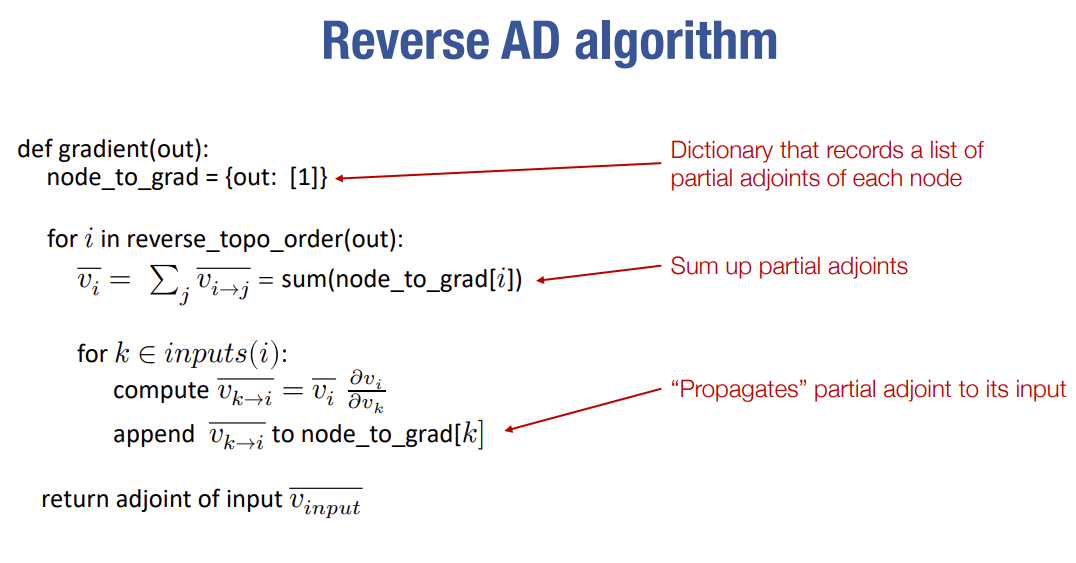

As discussed in lecture the result of reverse mode AD is still a computational graph. We can extend that graph further by composing more operations and run reverse mode AD again on the gradient (the last two tests of this problem).

In [11]:
!python -m pytest -k "compute_gradient"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 28 deselected / 1 selected                                

tests/hw1/test_autograd_hw.py .                                          [100%]

======================= 1 passed, 28 deselected in 0.62s =======================


## Question 5: Softmax loss [10 pts]

The following questions will be tested using the MNIST dataset, so we will use the `parse_mnist` function we wrote in the Homework 0.

1. First, copy and paste your solution to Question 2 of Homework 0 to the `parse_mnist` function in the `apps/simple_ml.py` file.  

In this question, you will implement the softmax loss as defined in the `softmax_loss()` function in `apps/simple_ml.py`, which we defined in Question 3 of Homework 0, except this time, the softmax loss takes as input a `Tensor` of logits and a `Tensor` of one hot encodings of the true labels. As a reminder, for a multi-class output that can take on values $y \in \{1,\ldots,k\}$, the softmax loss takes as input a vector of logits $z \in \mathbb{R}^k$, the true class $y \in \{1,\ldots,k\}$ (which is encoded for this function as a one-hot-vector) returns a loss defined by
\begin{equation}
\ell_{\mathrm{softmax}}(z, y) = ( \log\sum_{i=1}^k \exp z_i ) - z_y.
\end{equation}

2. Implement the function `softmax_loss` in `apps/simple_ml.py`.

You can start with your solution from Homework 0, and then modify it to be compatible with `needle` objects and operations. As with the previous homework, the function you implement should compute the _average_ softmax loss over a batch of size $m$, i.e. logits `Z` will be an $m \times k$ `Tensor` where each row represents one example, and `y_one_hot` will be an $m \times k$ `Tensor` that contains all zeros except for a 1 in the element corresponding to the true label for each row. Finally, note that the average softmax loss returned should also be a `Tensor`.

In [12]:
!python -m pytest -k "softmax_loss_ndl"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 28 deselected / 1 selected                                

tests/hw1/test_autograd_hw.py .                                          [100%]

======================= 1 passed, 28 deselected in 2.15s =======================


## Question 6: SGD for a two-layer neural network [10 pts]

As you did in Homework 0, you will now implement stochastic gradient descent (SGD) for a simple two-layer neural network as defined in Question 5 of Homework 0.

Specifically, for input $x \in \mathbb{R}^n$, we'll consider a two-layer neural network (without bias terms) of the form
\begin{equation}
z = W_2^T \mathrm{ReLU}(W_1^T x)
\end{equation}
where $W_1 \in \mathbb{R}^{n \times d}$ and $W_2 \in \mathbb{R}^{d \times k}$ represent the weights of the network (which has a $d$-dimensional hidden unit), and where $z \in \mathbb{R}^k$ represents the logits output by the network.  We again use the softmax / cross-entropy loss, meaning that we want to solve the optimization problem, overloading the notation to describe the batch form with matrix $X \in \mathbb{R}^{m \times n}$:
\begin{equation}
\min_{W_1, W_2} \;\; \ell_{\mathrm{softmax}}(\mathrm{ReLU}(X W_1) W_2, y).
\end{equation}


First, you will need to implement the forward and backward passes of the `relu` operator.
1. Begin by filling out the function `ReLU` operator in `python/needle/ops/ops_mathematic.py`.
2. Then fill out the `gradient` function of the class `ReLU` in `python/needle/ops/ops_mathematic.py`.  **Note that in this one case it's acceptable to access the underlying NDArray data (via `.realize_cached_data()` call, eg `node.inputs[0].realize_cached_data()`), since the ReLU function is not twice differentiable anyway**.

Then,

3. Fill out the `nn_epoch` method in the `apps/simple_ml.py` file.

Again, you can use your solution in Homework 0 for the `nn_epoch` function as a starting point. Note that unlike in Homework 0, the inputs `W1` and `W2` are `Tensors`. Inputs `X` and `y` however are still numpy arrays - you should iterate over minibatches of the numpy arrays `X` and `y` as you did in Homework 0, and then cast each `X_batch` as a `Tensor`, and one hot encode `y_batch` and cast as a `Tensor`. While last time we derived the backpropagation equations for this two-layer ReLU network directly, this time we will be using our autodifferentiation engine to compute the gradients generically by calling the `.backward()` method of the `Tensor` class. For each minibatch, after calling `.backward`, you should compute the updated values for `W1` and `W2` in `numpy`, and then create new `Tensors` for `W1` and `W2` with these `numpy` values. Your solution should return the final `W1` and `W2` `Tensors`.

Tip: the below unit test should finish quite quickly, within ~10 seconds. If the below cell is taking significantly longer, it is likely that you are unnecessarily adding the model parameter update operations to the computation graph. Another symptom of this is if the CPU memory slowly grows over time (corresponding to the computation graph growing after each batch).

One solution is to ensure that you are detaching the model parameter tensors (eg W1, W2) after each minibatch update. For instance, you may find the `Tensor.data()` method useful.

In [18]:
!python -m pytest -l -k "nn_epoch_ndl"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/data188/hw1
plugins: anyio-4.12.1, typeguard-4.4.4, langsmith-0.7.3
collected 29 items / 28 deselected / 1 selected                                

tests/hw1/test_autograd_hw.py .                                          [100%]

======================= 1 passed, 28 deselected in 5.92s =======================


After you've implemented all of the above, you should be able to train a two-layer neural network MNIST digit classifier! Run the below cell to train a model. For fun, feel free to play around with the model hyperparameters (hidden_dim, learning rate, batchsize) to see how changes affect both classification accuracy as well as training time.

With default params (`hidden_dim=400, epochs=3, lr=0.2, batch=100`), you should be able to get ~3.1% test error.
On my end, it takes ~30 seconds to train the model (10 secs per epoch).

For reference: "loss" is the cross-entropy loss, averaged over the the train/test dataset. "error" is classification error (eg 0-1 loss) averaged over the train/test dataset.

| Epoch | Train Loss | Train Err | Test Loss | Test Err | secs |
|    -1 |    3.74599 |   0.87177 |   3.77834 |  0.87300 | -1.00 |
|     0 |    0.15705 |   0.04803 |   0.16821 |  0.05100 | 12.30 |
|     1 |    0.09849 |   0.02912 |   0.11633 |  0.03680 | 10.37 |
|     2 |    0.07329 |   0.02157 |   0.09732 |  0.03100 | 13.84 |
Finished training (42.8636secs)
{'train_losses': [array(3.74599127), array(0.15704914), array(0.09848773), array(0.07328537)], 'train_errs': [np.float64(0.8717666666666667), np.float64(0.04803333333333333), np.float64(0.029116666666666666), np.float64(0.021566666666666668)], 'test_losses': [array(3.77833888), array(0.16821473), array(0.11632905), array(0.09731725)], 'test_errs': [np.float64(0.873), np.float64(0.051), np.float64(0.0368), np.float64(0.031)], 'epoch_durs': [12.30233907699585, 10.370424509048462, 13.836127281188965]}


/content/drive/MyDrive/data188/hw1/python/needle/utils/visualize.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_loss, ax_error) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


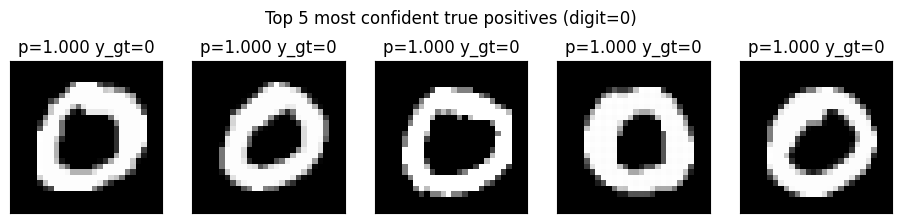

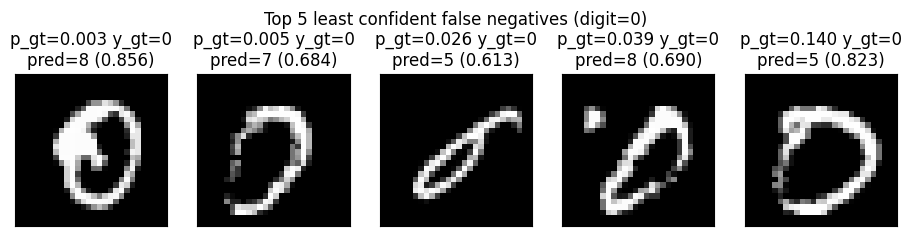

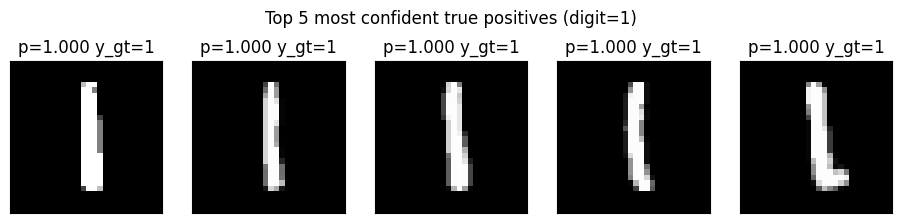

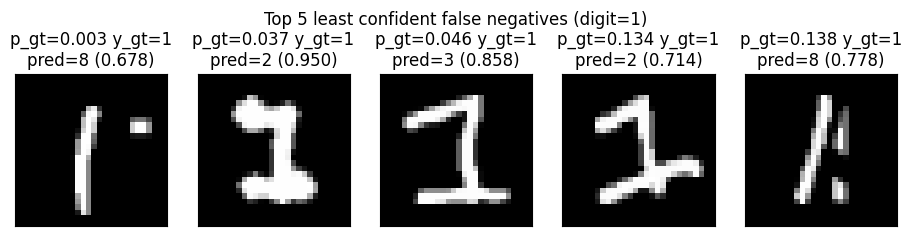

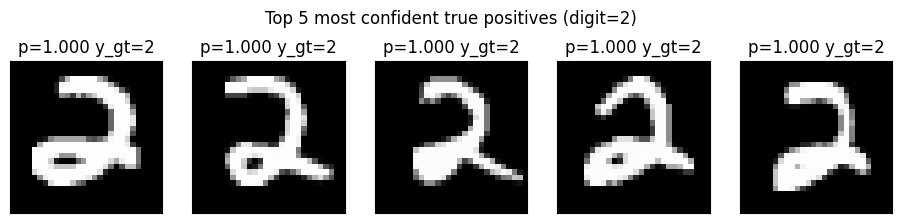

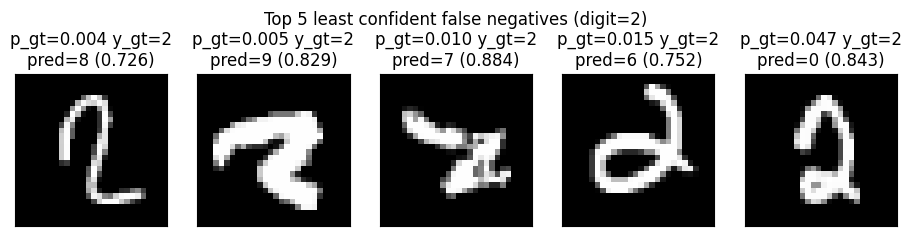

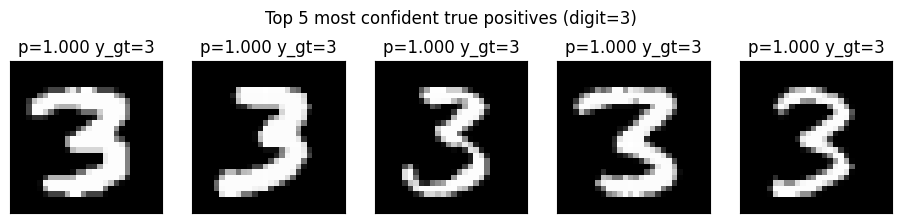

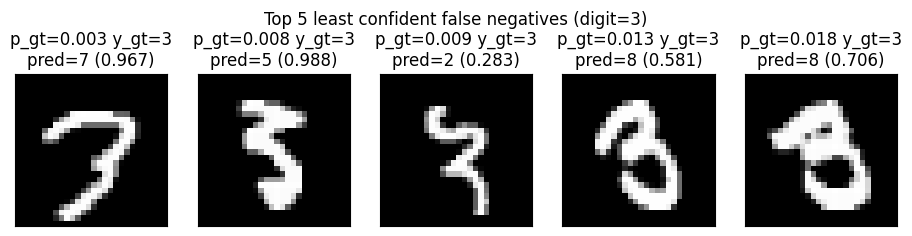

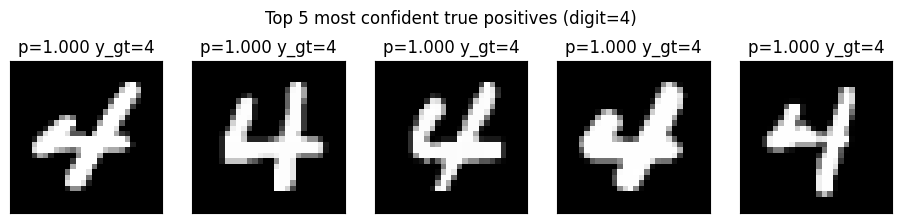

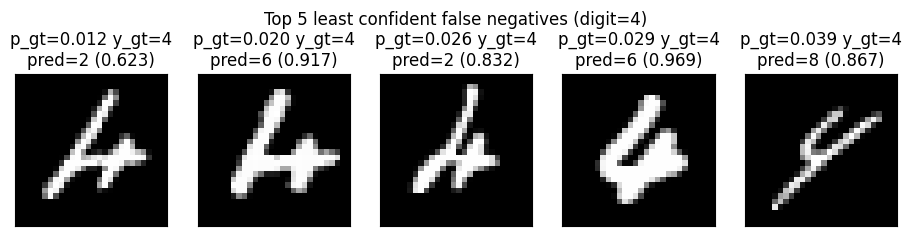

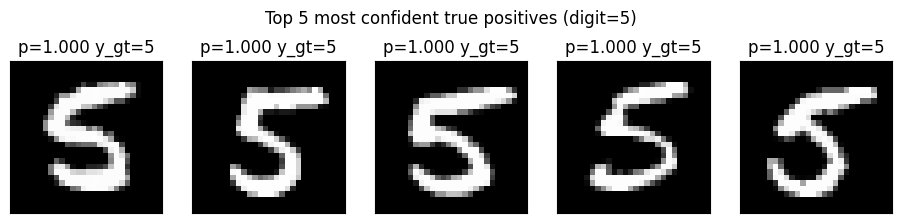

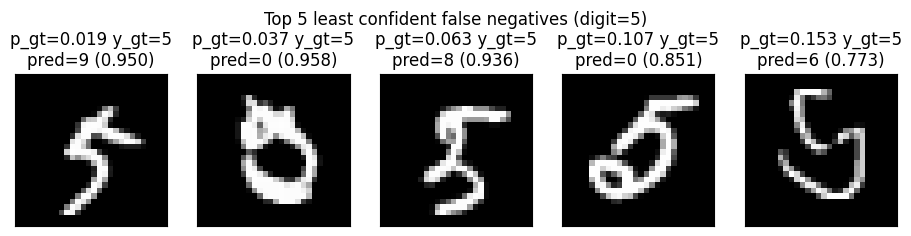

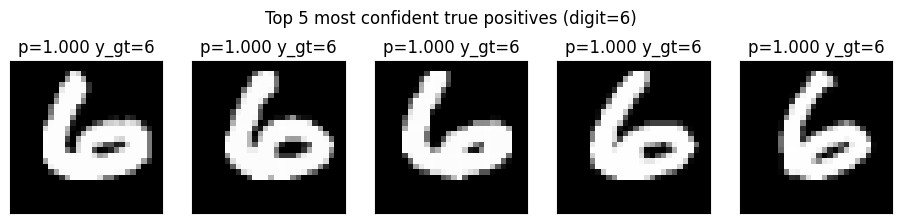

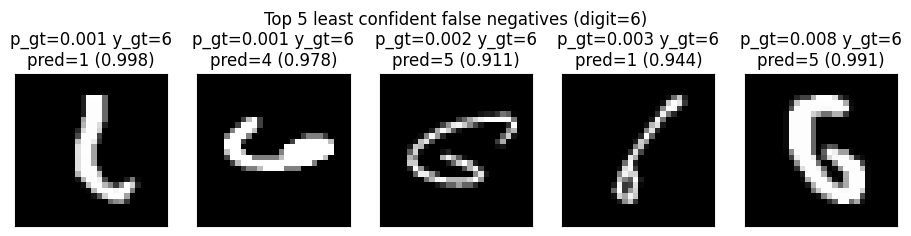

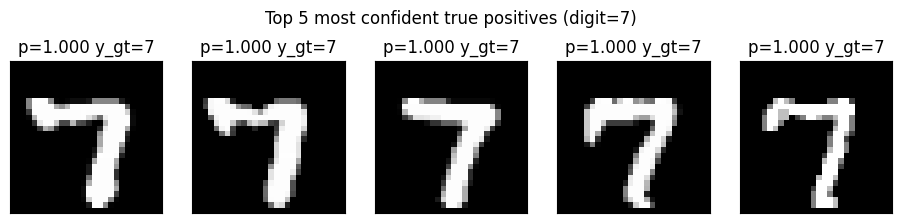

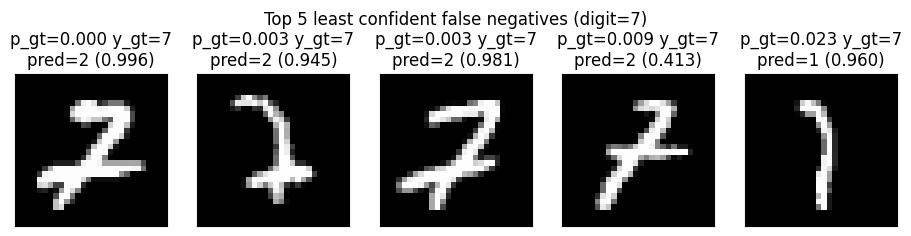

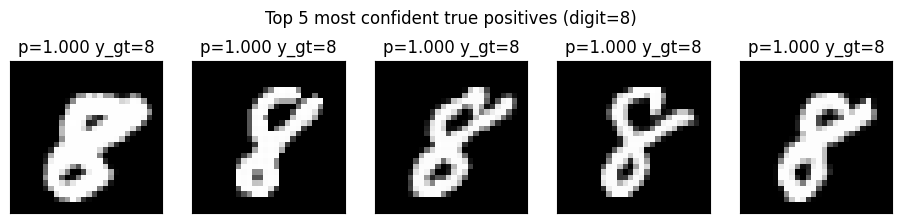

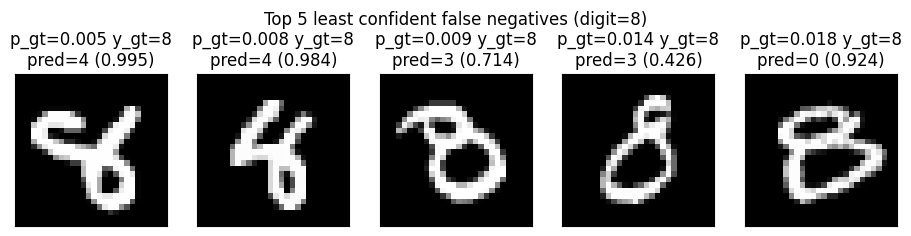

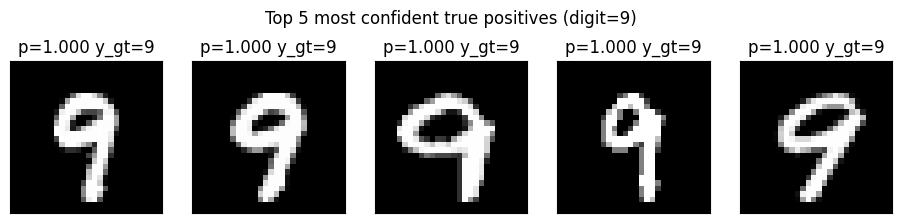

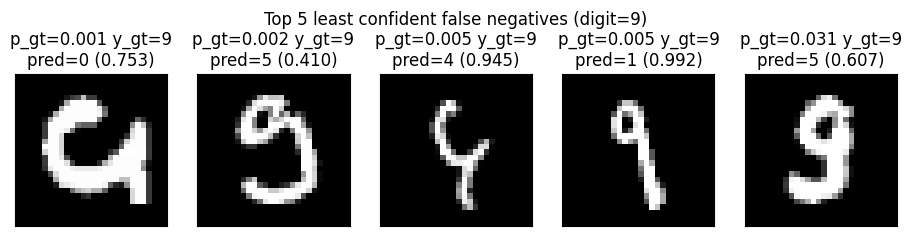

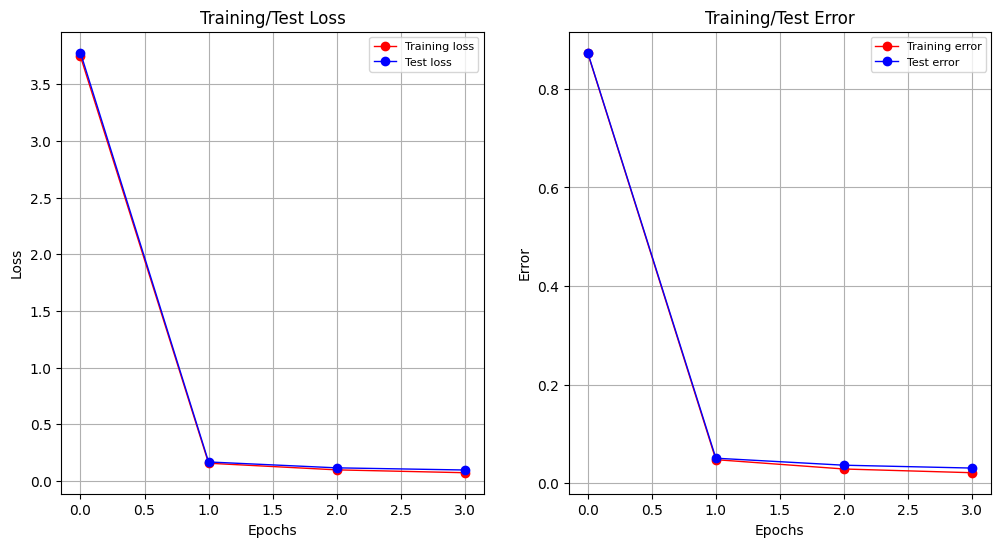

In [19]:
# Train a two-layer neural network on MNIST digit classification dataset, visualize
# predictions, and plot train/test loss+error.
import importlib
import time
from apps.simple_ml import train_nn_two_layer_mnist, parse_mnist
import needle
importlib.reload(needle)
from needle.utils.visualize import plot_train_test_curves

X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                        "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                        "data/t10k-labels-idx1-ubyte.gz")
tic0 = time.time()
(W1, W2), train_meta = train_nn_two_layer_mnist(
    X_tr, y_tr, X_te, y_te,
    hidden_dim=400,
    epochs=3,
    lr=0.2,
    batch=100,
    visualize_preds=True
)
dur_train = time.time() - tic0
print(f"Finished training ({dur_train:.4f}secs)")
print(train_meta)
fig = plot_train_test_curves(train_meta["train_losses"], train_meta["train_errs"], train_meta["test_losses"], train_meta["test_errs"])

## Homework Submission

To submit your homework assignment, we will do two things:
(1) Package your code (and any produced artifacts like model weights, etc) into a zip file
(2) Submit your zip file to Gradescope.

Once you've submitted to Gradescope, the Gradescope autograder will run and assign your earned points. Run the below cell to prepare+download your submission zip file:

In [20]:
# Packages code+artifacts into zip file, and download it to your local machine
# Tip: the zip file will be downloaded to your browser's default download folder, eg `~/Downloads, C:\Users\YourUserName\Downloads`, etc.
# IMPORTANT: be sure that `root_folder` is defined correctly in previous cell
from utils_public.utils import run_cmd

os.chdir(rootdir_asn)
print("cwd: ", os.getcwd())  # make sure we are in the right dir
print("ls cwd: ", os.listdir(os.getcwd()))

zip_outpath = f"{asn_name}_submission.zip"
print(f"Creating zip file (zip_outpath={zip_outpath})...")
run_cmd(["bash", "./utils_public/prepare_submission.sh", zip_outpath])
print("Created zipfile!")

# Check if filesize is too big
filesize_mb = os.path.getsize(zip_outpath) / (1024 * 1024)
print(f"Zip file size: {filesize_mb} MB")
if filesize_mb > 20:
    print(f"Warning: your submission zip is very large, and may result in autograder issues. Please investigate, perhaps you accidentally included unnecessary files?")

# Download created zipfile to your local machine
from google.colab import files
files.download(zip_outpath)
print(
    f"Finished downloading {zip_outpath}! Upload this zip file to Gradescope as your submission to run the autograder. "
    "\nThe zip file will be in your browser's default download directory, eg '~/Downloads', 'C:\\Users\\YourUserName\\Downloads', etc"
)

cwd:  /content/drive/MyDrive/data188/hw1
ls cwd:  ['.git', '.gitattributes', '.gitignore', 'LICENSE', 'README.md', 'apps', 'data', 'hw1.ipynb', 'python', 'tests', 'utils_public', '.pytest_cache']
Creating zip file (zip_outpath=hw1_submission.zip)...
(stdout):
  adding: LICENSE (deflated 65%)
  adding: README.md (deflated 35%)
  adding: apps/ (stored 0%)
  adding: apps/hw1_runners.py (deflated 56%)
  adding: apps/simple_ml.py (deflated 67%)
  adding: hw1.ipynb (deflated 34%)
  adding: python/ (stored 0%)
  adding: python/needle/ (stored 0%)
  adding: python/needle/__init__.py (deflated 42%)
  adding: python/needle/autograd.py (deflated 72%)
  adding: python/needle/backend_numpy.py (deflated 68%)
  adding: python/needle/init/ (stored 0%)
  adding: python/needle/init/__init__.py (stored 0%)
  adding: python/needle/init/init_basic.py (deflated 79%)
  adding: python/needle/ops/ (stored 0%)
  adding: python/needle/ops/__init__.py (stored 0%)
  adding: python/needle/ops/ops_mathematic.py (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finished downloading hw1_submission.zip! Upload this zip file to Gradescope as your submission to run the autograder. 
The zip file will be in your browser's default download directory, eg '~/Downloads', 'C:\Users\YourUserName\Downloads', etc
